# Libraries

In [1]:
# General System Libs
import os
import PIL.Image
import PIL.ImageEnhance

# Data Processing and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning Libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import mixed_precision
from keras.models import Model
from keras.layers import (
    Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,
    GlobalAveragePooling2D, Input, MaxPool2D
)
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LambdaCallback

In [2]:
# Set your directories and classes
DATA_DIR = r"D:\Comparative-Study-of-CNN-Architectures-for-Leukemia\dataset\Original"
train_dir = DATA_DIR
test_dir = DATA_DIR
CLASSES = ['Benign', 'Early', 'Pre', 'Pro']

In [3]:
# Image dimensions
img_height = 224
img_width = 224

# Function to count images in each class
def count_images(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

# Count images in each class
class_counts = {cls: count_images(os.path.join(DATA_DIR, cls)) for cls in CLASSES}
print("Original class counts:", class_counts)

Original class counts: {'Benign': 1000, 'Early': 1000, 'Pre': 1000, 'Pro': 1000}


# Data Pre-Processing

- Load all training and testing data

- Dividing the dataset into Training and Validation sets

- Center Cropping Images (Grayscaling -> Gaussian Blur -> Thresholding -> Find Contours -> Find Extreme Points

- Saved the Pre-Processing into a ./cleaned folder

- Pre-processing images (Resize to 224)

- Normalize images with MinMax Normalization

In [4]:
# Create TensorFlow datasets from directories
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=128
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=128
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=None,
    subset=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=128
)

Found 4000 files belonging to 4 classes.
Using 2800 files for training.
Found 4000 files belonging to 4 classes.
Using 1200 files for validation.
Found 4000 files belonging to 4 classes.


In [5]:
# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [6]:
# Optimize the dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Convert labels to pandas Series for plotting
train_labels = []
for img, label in train_ds.unbatch():
    train_labels.append(label.numpy())
train_labels_series = pd.Series(train_labels)

val_labels = []
for img, label in val_ds.unbatch():
    val_labels.append(label.numpy())
val_labels_series = pd.Series(val_labels)

test_labels = []
for img, label in test_ds.unbatch():
    test_labels.append(label.numpy())
test_labels_series = pd.Series(test_labels)

In [8]:
# Define data distribution counts
data_distribution_train = train_labels_series.value_counts()
data_distribution_val = val_labels_series.value_counts()
data_distribution_test = test_labels_series.value_counts()

C:\Users\Kevin Nathanael\AppData\Local\Temp\ipykernel_10820\2374562330.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[CLASSES[curr_index] for curr_index in data_distribution_train.index],


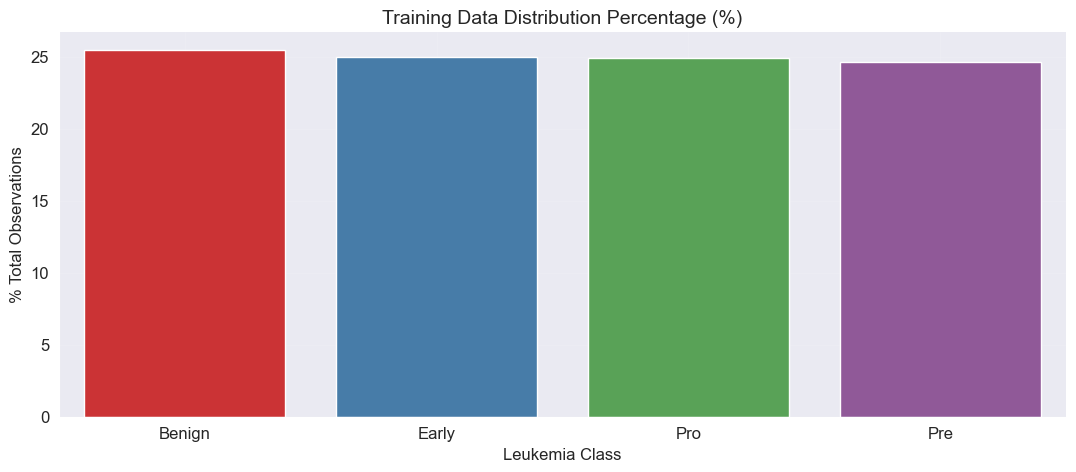

In [9]:
# Plot Training Data Distribution Percentage
plt.figure(figsize=(13, 5))
ax = sns.barplot(x=[CLASSES[curr_index] for curr_index in data_distribution_train.index],
                 y=100 * (data_distribution_train / data_distribution_train.sum()),
                 palette='Set1')
plt.grid(True, alpha=0.1)
plt.title("Training Data Distribution Percentage (%)", fontsize=14)
plt.xlabel("Leukemia Class", fontsize=12)
plt.ylabel("% Total Observations", fontsize=12)
plt.tick_params(which='major', labelsize=12)
sns.despine()
plt.show()

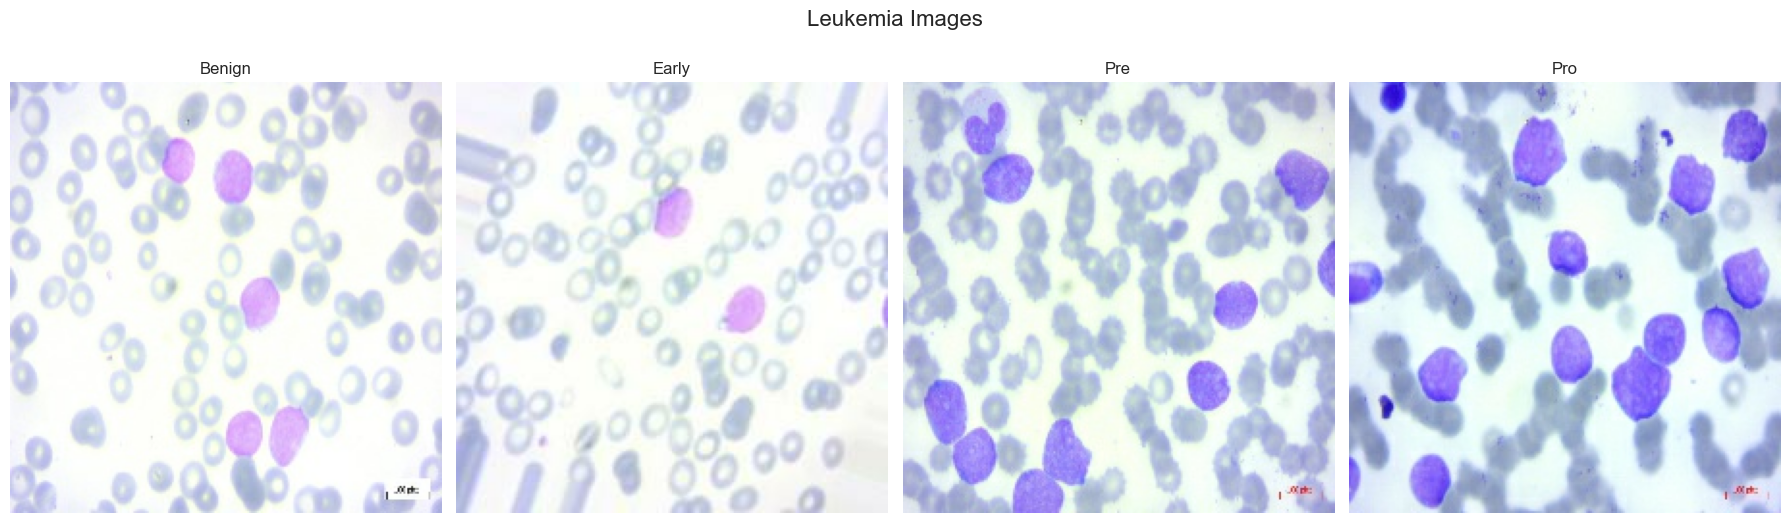

In [10]:
# Plot leukemia images
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))
axes = axes.flatten()
fig.suptitle("Leukemia Images", fontsize=16, fontdict=dict(weight='bold'), y=1.04)

for curr_title, (image_tensor, label), curr_axis in zip(CLASSES, train_ds.take(4), axes[:4]):
    # Properly reshape and convert the image tensor
    curr_image = tf.squeeze(image_tensor)  # Remove batch dimension if present
    
    # Ensure the image is in the correct shape (height, width, channels)
    if len(curr_image.shape) == 4:  # If still 4D
        curr_image = curr_image[0]  # Remove extra dimension
    
    # Convert to numpy array and ensure uint8 data type with correct value range
    curr_image = curr_image.numpy()
    
    if curr_image.max() <= 1.0:
        curr_image = (curr_image * 255).astype(np.uint8)
    else:
        curr_image = curr_image.astype(np.uint8)
    
    # Create PIL Image and enhance brightness
    img_enhancer = PIL.ImageEnhance.Brightness(PIL.Image.fromarray(curr_image))
    curr_axis.imshow(img_enhancer.enhance(1))
    curr_axis.set_title(curr_title)
    curr_axis.axis('off')

plt.tight_layout()
plt.show()

# InceptionResNetV2

In [11]:
base_model_inceptionresnetv2 = InceptionResNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

## Tag 1
- Architecture: InceptionResNetV2 - ImageNet
- Batch_Size: 10
- Dropout: 0.4*
- Epoch: 20
- Learning_Rate: 0.01*
- Optimizer: Adam

In [12]:
x = base_model_inceptionresnetv2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions_inceptionresnetv2 = Dense(4, activation='softmax')(x)
model_inceptionresnetv2 = Model(inputs=base_model_inceptionresnetv2.inputs, outputs=predictions_inceptionresnetv2)

adam = keras.optimizers.Adam(learning_rate=0.01)
model_inceptionresnetv2.compile(optimizer=adam,
                    loss=tf.losses.SparseCategoricalCrossentropy(), # -> Pengganti One Hot Encoding
                    metrics=['accuracy'])
model_inceptionresnetv2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
RL = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.3,
                       patience=5,
                       verbose=1,
                       mode='min')

# Create a list of callbacks
callbacks = [RL]

In [21]:
# Set mixed precision policy
mixed_precision.set_global_policy('mixed_float16')

with tf.device('/GPU:0'):
    history_inceptionresnetv2 = model_inceptionresnetv2.fit(
        train_ds,
        validation_data=test_ds,
        epochs=20,
        callbacks=callbacks,
        batch_size=10,
        verbose=1
    )

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'model/batch_normalization_2/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue
      await self.process_one()
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 518, in process_one
      await dispatch(*args)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell
      await result
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 766, in execute_request
      reply_content = await reply_content
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Kevin Nathanael\AppData\Local\Temp\ipykernel_10820\1851261269.py", line 5, in <module>
      history_inceptionresnetv2 = model_inceptionresnetv2.fit(
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/batch_normalization_2/FusedBatchNormV3'
OOM when allocating tensor with shape[128,64,61,61] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/batch_normalization_2/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_68014]

In [ ]:
# Evaluate the model on the training data
train_loss, train_acc = model_inceptionresnetv2.evaluate(train_ds)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_acc}")

# Evaluate the model on the validation data
val_loss, val_acc = model_inceptionresnetv2.evaluate(val_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Evaluate the model on the test data
test_loss, test_acc = model_inceptionresnetv2.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

In [ ]:
# Make predictions on the validation dataset
predictions = model_inceptionresnetv2.predict(val_ds)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=CLASSES)
print(report)

In [ ]:
# Calculate best epochs
tr_acc = history_inceptionresnetv2.history['accuracy']
index_acc = np.argmax(tr_acc)  # Find epoch with highest training accuracy
index_loss = np.argmin(history_inceptionresnetv2.history['loss'])  # Find epoch with lowest training loss

# Plot accuracy and loss curves
acc = history_inceptionresnetv2.history['accuracy']
val_acc = history_inceptionresnetv2.history['val_accuracy']
loss = history_inceptionresnetv2.history['loss']
val_loss = history_inceptionresnetv2.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

# Accuracy plot
plt.figure(figsize=[8, 6])
plt.plot(Epochs, acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b', label='Validation Accuracy')
plt.axvline(x=index_acc + 1, color='g', linestyle='--', label=f'Best epoch = {index_acc + 1}')
plt.title('InceptionResNetV2 Model | Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=[8, 6])
plt.plot(Epochs, loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'b', label='Validation Loss')
plt.axvline(x=index_loss + 1, color='g', linestyle='--', label=f'Best epoch = {index_loss + 1}')
plt.title('InceptionResNetV2 Model | Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()